# Statistical Tests

This notebook is used to perform the statistical tests as reported in the paper (in addition to a few extra ones).

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols, rlm
from scipy.stats import linregress
from IPython.display import display

from plot_funcs import (get_results, plot_avg_ranks, get_mean_avg_ranks,
                        clean_model_names, get_ranks_sizes,
                        get_highest_performing_df, get_cut_off_df,
                        get_across_ranks, get_intra_pipeline_df,
                        get_single_vs_multiple_df, get_model_avg_ranks, get_results_df)
from funcs import save_stats_summary, save_results_table

In [2]:
results = get_results('../exp/results')
static = {'random': True, 'base': True, 'fs': True, 'ico': True}

Found: 64530 Incomplete: 0


# Averaged Performance-Size Scaling

This test corresponds to Figure 2 in the manuscript, what we want to test here is the relationship between Mean Rank and size and then as further influenced by type of parcellation.

In [3]:
r_df = get_ranks_sizes(results, log=True,
                       threshold=True, **static)
model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
save_stats_summary(model, 'base_results1')
print(model.pvalues)

model.summary()

2 -12
Smallest size: 7.0
Largest size: 4000.0
Intercept                                       7.686344e-220
C(Parcellation_Type)[T.Freesurfer Extracted]     7.137494e-01
C(Parcellation_Type)[T.Icosahedron]              8.735560e-01
C(Parcellation_Type)[T.Random]                   7.082816e-08
Size                                            1.984630e-101
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     459.6
Date:                Wed, 30 Jun 2021   Prob (F-statistic):          6.68e-100
Time:                        11:29:44   Log-Likelihood:                 294.79
No. Observations:                 206   AIC:                            -579.6
Df Residuals:                     201   BIC:                            -562.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        2.6119      0.015    171.406      0.000       2.582       2.642
C(Parcellation_Type)[T.Freesurfer Extracted]     0.0154      0.042      0.367      0.714      -0.067       0.098
C(Parcellation_Type)[T.Icosahedron]             -0.0040      0.025     -0.159      0.874      -0.054       0.046
C(Parcellation_Type)[T.Random]                   0.0485      0.009      5.597      0.000       0.031       0.066
Size                                            -0.2774      0.007    -41.980      0.000      -0.290      -0.264
==============================================================================
Omnibus:                        2.053   Durbin-Watson:                   1.411
Prob(Omnibus):                  0.358   Jarque-Bera (JB):                1.822
Skew:                           0.080   Prob(JB):                        0.402
Kurtosis:                       3.432   Cond. No.                         26.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Only the difference between existing and random have enough statistical power.

### Viz just the fits for Existing vs. Random:

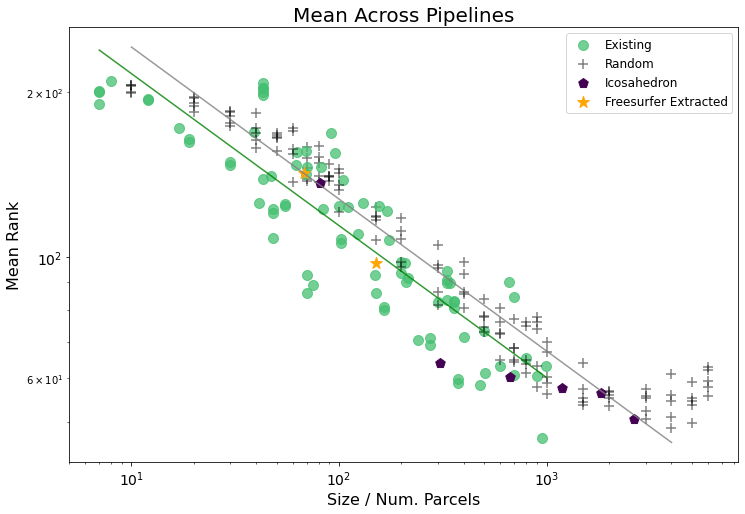

In [4]:
# Gen plot
_, ax = plt.subplots(figsize=(12, 8))

# Reverse log10 on size
e_size = 10 ** r_df['Size'][r_df['Parcellation_Type'] == 'Existing']
r_size = 10 ** r_df['Size'][r_df['Parcellation_Type'] == 'Random']

# Get pred fit lines
e_fit = 10 ** model.params.Intercept * (e_size **(model.params.Size))

r_intercept = 10 ** (model.params.Intercept + model.params['C(Parcellation_Type)[T.Random]'])
r_fit = r_intercept * (r_size **(model.params.Size))

# Plot lines of fit
ax.plot(e_size, e_fit, color='green', alpha=.8)
ax.plot(r_size, r_fit, color='gray', alpha=.8)

# Add main plot
plot_avg_ranks(results,
               log=True,
               ax=ax, **static)

plt.savefig('Figures/base_results_fit1.png', dpi=300, bbox_inches='tight')

### We want to next check if there is a possible interaction between parcellation type and size.

Intercept                                            1.718956e-166
C(Parcellation_Type)[T.Freesurfer Extracted]          4.003156e-01
C(Parcellation_Type)[T.Icosahedron]                   5.453467e-01
C(Parcellation_Type)[T.Random]                        3.532441e-01
Size                                                  1.336250e-54
Size:C(Parcellation_Type)[T.Freesurfer Extracted]     4.158092e-01
Size:C(Parcellation_Type)[T.Icosahedron]              5.426060e-01
Size:C(Parcellation_Type)[T.Random]                   6.008735e-01
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     260.5
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           3.02e-96
Time:                        11:29:49   Log-Likelihood:                 295.43
No. Observations:                 206   AIC:                            -574.9
Df Residuals:                     198   BIC:                            -548.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             2.6247      0.028     94.291      0.000       2.570       2.680
C(Parcellation_Type)[T.Freesurfer Extracted]          0.4112      0.488      0.843      0.400      -0.551       1.373
C(Parcellation_Type)[T.Icosahedron]                  -0.0836      0.138     -0.606      0.545      -0.356       0.189
C(Parcellation_Type)[T.Random]                        0.0314      0.034      0.931      0.353      -0.035       0.098
Size                                                 -0.2835      0.013    -21.830      0.000      -0.309      -0.258
Size:C(Parcellation_Type)[T.Freesurfer Extracted]    -0.1977      0.242     -0.815      0.416      -0.676       0.280
Size:C(Parcellation_Type)[T.Icosahedron]              0.0297      0.049      0.610      0.543      -0.066       0.126
Size:C(Parcellation_Type)[T.Random]                   0.0079      0.015      0.524      0.601      -0.022       0.038
==============================================================================
Omnibus:                        1.807   Durbin-Watson:                   1.422
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                1.521
Skew:                           0.080   Prob(JB):                        0.467
Kurtosis:                       3.390   Cond. No.                         406.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

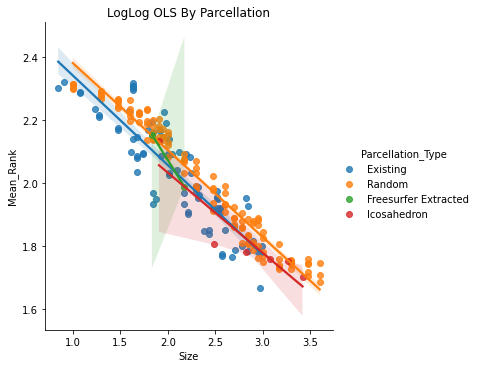

In [5]:
g = sns.lmplot(y='Mean_Rank', x='Size', data=r_df, hue='Parcellation_Type')

plt.title('LogLog OLS By Parcellation')
plt.savefig('Figures/base_results_fit2.png', dpi=200, bbox_inches='tight')

model = ols('Mean_Rank ~ Size * C(Parcellation_Type)', data=r_df).fit()
save_stats_summary(model, 'base_results2')
print(model.pvalues)
model.summary()

No interactions are signifigant here.


### How does the estimated slope change w/ robust regression?
Next, we will see how the results change when using robust regression and no thresholding, where thresholding = the procedure for selecting the region in which the scaling holds.

In [6]:
r_df = get_ranks_sizes(results, log=True, **static)

model = rlm('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

Intercept                                       0.000000e+00
C(Parcellation_Type)[T.Freesurfer Extracted]    6.317907e-01
C(Parcellation_Type)[T.Icosahedron]             7.308874e-01
C(Parcellation_Type)[T.Random]                  1.392277e-09
Size                                            0.000000e+00
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:              Mean_Rank   No. Observations:                  220
Model:                            RLM   Df Residuals:                      215
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 30 Jun 2021                                         
Time:                        11:29:49                                         
No. Iterations:                    19                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        2.5664      0.014    179.972      0.000       2.538       2.594
C(Parcellation_Type)[T.Freesurfer Extracted]     0.0211      0.044      0.479      0.632      -0.065       0.108
C(Parcellation_Type)[T.Icosahedron]             -0.0091      0.027     -0.344      0.731      -0.061       0.043
C(Parcellation_Type)[T.Random]                   0.0549      0.009      6.056      0.000       0.037       0.073
Size                                            -0.2575      0.006    -42.180      0.000      -0.269      -0.246
================================================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

# Choice of Pipeline

### Intra-Pipeline Comparison

0 -16
Smallest size: 7.0
Largest size: 3000.0
0 -27
Smallest size: 7.0
Largest size: 1500.0
17 -5
Smallest size: 20.0
Largest size: 5000.0
Intercept                    0.000000e+00
C(Pipeline)[T.LGBM]          4.270755e-01
C(Pipeline)[T.SVM]           1.757094e-25
Size                        2.342572e-122
Size:C(Pipeline)[T.LGBM]     1.604457e-01
Size:C(Pipeline)[T.SVM]      1.486984e-25
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     878.8
Date:                Wed, 30 Jun 2021   Prob (F-statistic):          2.48e-270
Time:                        11:29:52   Log-Likelihood:                 746.28
No. Observations:                 595   AIC:                            -1481.
Df Residuals:                     589   BIC:                            -1454.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.5893      0.019    135.246      0.000       2.552       2.627
C(Pipeline)[T.LGBM]         -0.0208      0.026     -0.795      0.427      -0.072       0.031
C(Pipeline)[T.SVM]           0.3020      0.028     10.939      0.000       0.248       0.356
Size                        -0.2606      0.009    -30.318      0.000      -0.278      -0.244
Size:C(Pipeline)[T.LGBM]     0.0162      0.012      1.405      0.160      -0.006       0.039
Size:C(Pipeline)[T.SVM]     -0.1291      0.012    -10.957      0.000      -0.152      -0.106
==============================================================================
Omnibus:                       69.048   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.291
Skew:                          -0.791   Prob(JB):                     2.26e-23
Kurtosis:                       4.306   Cond. No.                         40.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

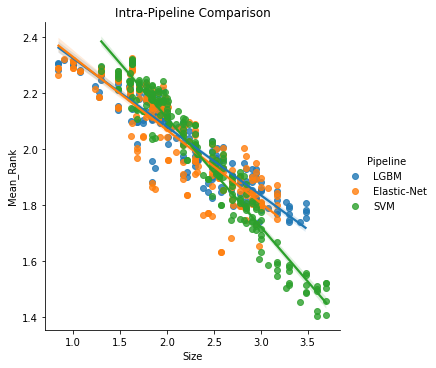

In [7]:
intra_pipe_df = get_intra_pipeline_df(results, log=True,
                                      threshold=True, **static).rename({'Model': 'Pipeline'}, axis=1)

# Plot
g = sns.lmplot(x='Size', y='Mean_Rank', hue='Pipeline', data=intra_pipe_df)
plt.title('Intra-Pipeline Comparison')
plt.savefig('Figures/intra_plot1.png', dpi=200, bbox_inches='tight')

# Run stats
model = ols('Mean_Rank ~ Size * C(Pipeline)', data=intra_pipe_df).fit()
save_stats_summary(model, 'intra_results1')
print(model.pvalues)
model.summary()

### Inter-Pipeline

Intercept                    0.000000e+00
C(Pipeline)[T.LGBM]          6.730472e-01
C(Pipeline)[T.SVM]           3.862000e-72
Size                        2.387482e-110
Size:C(Pipeline)[T.LGBM]     2.735790e-19
Size:C(Pipeline)[T.SVM]     7.991757e-107
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     1527.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:29:53   Log-Likelihood:                 744.73
No. Observations:                 660   AIC:                            -1477.
Df Residuals:                     654   BIC:                            -1450.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.8836      0.018    160.158      0.000       2.848       2.919
C(Pipeline)[T.LGBM]          0.0107      0.025      0.422      0.673      -0.039       0.061
C(Pipeline)[T.SVM]           0.5203      0.025     20.432      0.000       0.470       0.570
Size                        -0.2026      0.007    -27.342      0.000      -0.217      -0.188
Size:C(Pipeline)[T.LGBM]     0.0971      0.010      9.267      0.000       0.077       0.118
Size:C(Pipeline)[T.SVM]     -0.2798      0.010    -26.707      0.000      -0.300      -0.259
==============================================================================
Omnibus:                       26.081   Durbin-Watson:                   1.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.959
Skew:                          -0.393   Prob(JB):                     6.97e-08
Kurtosis:                       3.763   Cond. No.                         35.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

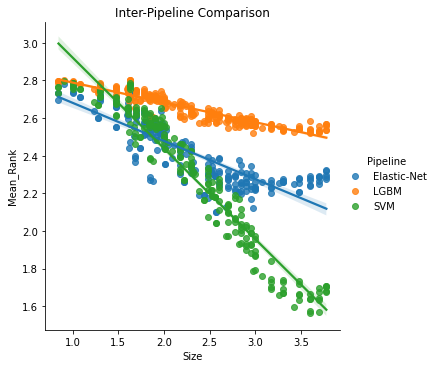

In [8]:
# Get df
inter_pipe_df = clean_model_names(
    get_across_ranks(results, log=True, **static).rename({'Model': 'Pipeline'}, axis=1))

# Plot
g = sns.lmplot(x='Size', y='Mean_Rank', hue='Pipeline', data=inter_pipe_df)
plt.title('Inter-Pipeline Comparison')
plt.savefig('Figures/inter_plot1.png', dpi=200, bbox_inches='tight')

model = ols('Mean_Rank ~ Size * C(Pipeline)', data=inter_pipe_df).fit()
save_stats_summary(model, 'inter_results1')
print(model.pvalues)
model.summary()

In [9]:
print('Elastic intercept vs. SVM intercept')
i = model.params.Intercept
i, i+model.params['C(Pipeline)[T.SVM]'], model.pvalues['C(Pipeline)[T.SVM]']

Elastic intercept vs. SVM intercept


(2.883642467779507, 3.4039069985519435, 3.8619997640547477e-72)

In [10]:
print('Elastic size coef vs. SVM interaction')
s = model.params.Size
s, s+model.params['Size:C(Pipeline)[T.SVM]'], model.pvalues['Size:C(Pipeline)[T.SVM]']

Elastic size coef vs. SVM interaction


(-0.20258096892392163, -0.4824219305823414, 7.991756862122724e-107)

# Variation Across Target Variable

Intercept    0.0
Size         0.0
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     9156.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:29:56   Log-Likelihood:                 1219.6
No. Observations:                9900   AIC:                            -2435.
Df Residuals:                    9898   BIC:                            -2421.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6315      0.007    360.421      0.000       2.617       2.646
Size          -0.2875      0.003    -95.690      0.000      -0.293      -0.282
==============================================================================
Omnibus:                     3039.933   Durbin-Watson:                   1.426
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15980.606
Skew:                          -1.382   Prob(JB):                         0.00
Kurtosis:                       8.577   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

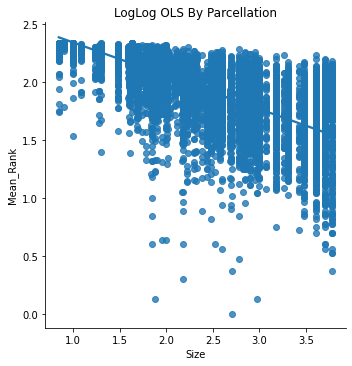

In [11]:
r_df = get_ranks_sizes(results, avg_targets=False,
                       log=True, threshold=False, **static)

sns.lmplot(y='Mean_Rank', x='Size', data=r_df)
plt.title('LogLog OLS By Parcellation')

model = ols('Mean_Rank ~ Size', data=r_df).fit()
save_stats_summary(model, 'by_target_table')
print(model.pvalues)
model.summary()

### Calculate IQR at every unique size, then fit a model explaining it in relation to size.

Intercept    1.134933e-11
Size         2.385354e-27
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    IQR   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     283.2
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           2.39e-27
Time:                        11:29:56   Log-Likelihood:                 109.80
No. Observations:                  78   AIC:                            -215.6
Df Residuals:                      76   BIC:                            -210.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1946      0.024     -7.993      0.000      -0.243      -0.146
Size           0.1740      0.010     16.829      0.000       0.153       0.195
==============================================================================
Omnibus:                        6.433   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                6.599
Skew:                           0.706   Prob(JB):                       0.0369
Kurtosis:                       2.802   Cond. No.                         9.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

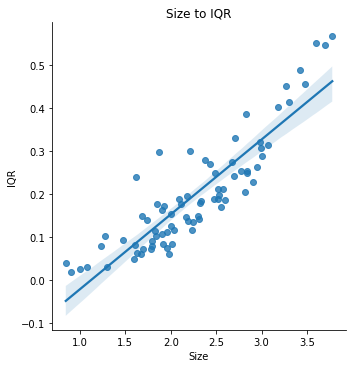

In [12]:
def v(x):
    rl = x['Mean_Rank']
    return rl.quantile(.75) - rl.quantile(.25)
    
log_size_to_var = r_df.groupby('Size').apply(v)
ls_df = log_size_to_var.to_frame().reset_index().rename(columns={0: 'IQR'})

g = sns.lmplot(y='IQR', x='Size', data=ls_df)
plt.title('Size to IQR')
plt.savefig('Figures/iqr.png', dpi=200, bbox_inches='tight')

model = ols('IQR ~ Size', data=ls_df).fit()
save_stats_summary(model, 'iqr_stats')
print(model.pvalues)
model.summary()

### Compare thresholded R2 at 4000 and less between variation models

In [13]:
# By Target
r_df = get_ranks_sizes(results, avg_targets=False,
                       log=True, threshold=False, **static)
r_df = r_df[r_df['Size'] <= np.log10(4000)]

model = ols('Mean_Rank ~ Size', data=r_df).fit()
print(model.pvalues)
display(model.summary())

print('')
print('---')
print('')

# Mean
r_df = get_ranks_sizes(results, avg_targets=True, log=True,
                       threshold=False, **static)
r_df = r_df[r_df['Size'] <= np.log10(4000)]

model = ols('Mean_Rank ~ Size', data=r_df).fit()
print(model.pvalues)
display(model.summary())

Intercept    0.0
Size         0.0
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     9040.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:29:59   Log-Likelihood:                 1753.1
No. Observations:                9450   AIC:                            -3502.
Df Residuals:                    9448   BIC:                            -3488.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6513      0.007    360.502      0.000       2.637       2.666
Size          -0.2976      0.003    -95.081      0.000      -0.304      -0.291
==============================================================================
Omnibus:                     3353.506   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21597.776
Skew:                          -1.554   Prob(JB):                         0.00
Kurtosis:                       9.722   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


---

Intercept    2.938587e-223
Size          6.190825e-99
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     1572.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           6.19e-99
Time:                        11:30:00   Log-Likelihood:                 280.52
No. Observations:                 210   AIC:                            -557.0
Df Residuals:                     208   BIC:                            -550.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6114      0.016    166.431      0.000       2.580       2.642
Size          -0.2648      0.007    -39.655      0.000      -0.278      -0.252
==============================================================================
Omnibus:                        7.873   Durbin-Watson:                   1.132
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.850
Skew:                          -0.470   Prob(JB):                       0.0197
Kurtosis:                       3.118   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Single vs. Multiple Parcellations

## 1. Compare Ensembles to Non-Ensembled Results

Intercept                    0.000000e+00
C(Is_Ensemble)[T.1]          5.649210e-34
Size                        2.430868e-129
Size:C(Is_Ensemble)[T.1]     3.532166e-61
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     3211.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):          2.50e-283
Time:                        11:30:02   Log-Likelihood:                 649.47
No. Observations:                 412   AIC:                            -1291.
Df Residuals:                     408   BIC:                            -1275.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.7859      0.011    248.940      0.000       2.764       2.808
C(Is_Ensemble)[T.1]          0.6148      0.046     13.348      0.000       0.524       0.705
Size                        -0.1635      0.005    -36.167      0.000      -0.172      -0.155
Size:C(Is_Ensemble)[T.1]    -0.2809      0.014    -19.696      0.000      -0.309      -0.253
==============================================================================
Omnibus:                       12.497   Durbin-Watson:                   0.988
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.545
Skew:                          -0.276   Prob(JB):                     0.000255
Kurtosis:                       3.812   Cond. No.                         63.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

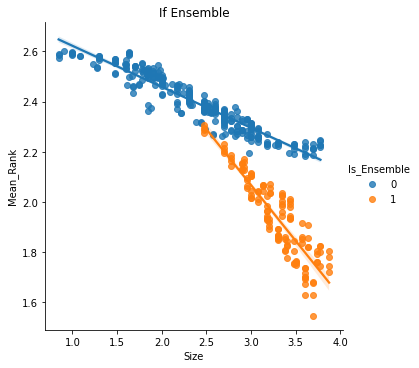

In [14]:
r_df = get_single_vs_multiple_df(results, threshold=False, log=True,
                                 stacked=True,
                                 voted=True, grid=True,
                                 **static).reset_index()

r_df = r_df.rename(columns={'is_ensemble': 'Is_Ensemble'})

# Plot
sns.lmplot(x='Size', y='Mean_Rank', hue='Is_Ensemble', data=r_df)
plt.title('If Ensemble')
plt.savefig('Figures/is_ensemble.png', dpi=200, bbox_inches='tight')

model = ols('Mean_Rank ~ Size * C(Is_Ensemble)', data=r_df).fit()
save_stats_summary(model, 'is_ensemble_stats')
print(model.pvalues)
model.summary()

In [15]:
model.params.Intercept, model.params.Intercept + model.params['C(Is_Ensemble)[T.1]'], model.pvalues['C(Is_Ensemble)[T.1]']

(2.7858533833717454, 3.4007007617880185, 5.649209949959936e-34)

In [16]:
model.params.Size, model.params.Size + model.params['Size:C(Is_Ensemble)[T.1]'], model.pvalues['Size:C(Is_Ensemble)[T.1]']

(-0.1634582947737117, -0.4443966385585022, 3.532165661349644e-61)

2. Compare Stacked vs. Voted Results

Intercept                        1.576421e-80
C(Parcellation_Type)[T.Voted]    3.199006e-01
Size                             1.033708e-39
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     190.5
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           1.12e-38
Time:                        11:30:02   Log-Likelihood:                 153.52
No. Observations:                 128   AIC:                            -301.0
Df Residuals:                     125   BIC:                            -292.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.0516      0.066     46.289      0.000       2.921       3.182
C(Parcellation_Type)[T.Voted]     0.0130      0.013      0.999      0.320      -0.013       0.039
Size                             -0.3872      0.020    -19.494      0.000      -0.426      -0.348
==============================================================================
Omnibus:                        4.165   Durbin-Watson:                   0.922
Prob(Omnibus):                  0.125   Jarque-Bera (JB):                3.461
Skew:                          -0.299   Prob(JB):                        0.177
Kurtosis:                       2.461   Cond. No.                         36.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

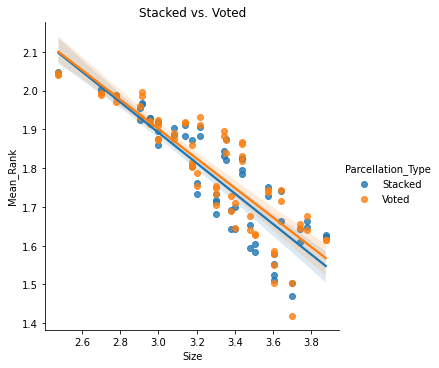

In [17]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False)

sns.lmplot(x='Size', y='Mean_Rank', hue='Parcellation_Type', data=r_df)
plt.title('Stacked vs. Voted')
plt.savefig('Figures/ensemble_method1.png', dpi=200, bbox_inches='tight')

model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
save_stats_summary(model, 'ensemble_method1')
print(model.pvalues)
model.summary()

Check for interactions

In [18]:
model = ols('Mean_Rank ~ Size * C(Parcellation_Type)', data=r_df).fit()
save_stats_summary(model, 'ensemble_method2')
print(model.pvalues)
model.summary()

Intercept                             2.994607e-63
C(Parcellation_Type)[T.Voted]         8.304037e-01
Size                                  3.412065e-27
Size:C(Parcellation_Type)[T.Voted]    7.531906e-01
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     126.1
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           1.66e-37
Time:                        11:30:02   Log-Likelihood:                 153.57
No. Observations:                 128   AIC:                            -299.1
Df Residuals:                     124   BIC:                            -287.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              3.0722      0.093     32.996      0.000       2.888       3.257
C(Parcellation_Type)[T.Voted]         -0.0283      0.132     -0.215      0.830      -0.289       0.232
Size                                  -0.3935      0.028    -13.957      0.000      -0.449      -0.338
Size:C(Parcellation_Type)[T.Voted]     0.0126      0.040      0.315      0.753      -0.066       0.091
==============================================================================
Omnibus:                        3.897   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.346
Skew:                          -0.301   Prob(JB):                        0.188
Kurtosis:                       2.485   Cond. No.                         94.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Check binary and regression only

Intercept                             1.782836e-54
C(Parcellation_Type)[T.Voted]         4.689850e-02
Size                                  9.350589e-15
Size:C(Parcellation_Type)[T.Voted]    4.347298e-03
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     107.8
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           2.14e-34
Time:                        11:30:03   Log-Likelihood:                 145.61
No. Observations:                 128   AIC:                            -283.2
Df Residuals:                     124   BIC:                            -271.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              2.7168      0.099     27.418      0.000       2.521       2.913
C(Parcellation_Type)[T.Voted]          0.2813      0.140      2.007      0.047       0.004       0.559
Size                                  -0.2643      0.030     -8.809      0.000      -0.324      -0.205
Size:C(Parcellation_Type)[T.Voted]    -0.1233      0.042     -2.905      0.004      -0.207      -0.039
==============================================================================
Omnibus:                        5.216   Durbin-Watson:                   0.971
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                4.893
Skew:                          -0.475   Prob(JB):                       0.0866
Kurtosis:                       3.124   Cond. No.                         94.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

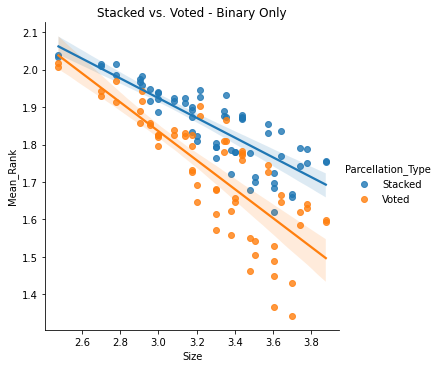

In [19]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False, binary_only=True)

sns.lmplot(x='Size', y='Mean_Rank', hue='Parcellation_Type', data=r_df)
plt.title('Stacked vs. Voted - Binary Only')
plt.savefig('Figures/ensemble_method_binary.png', dpi=200, bbox_inches='tight')

model = ols('Mean_Rank ~ Size * C(Parcellation_Type)', data=r_df).fit()
save_stats_summary(model, 'ensemble_method_binary')
print(model.pvalues)
model.summary()

Intercept                             2.795046e-59
C(Parcellation_Type)[T.Voted]         1.393627e-03
Size                                  5.291494e-33
Size:C(Parcellation_Type)[T.Voted]    3.549867e-05
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     160.2
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           1.77e-42
Time:                        11:30:04   Log-Likelihood:                 120.93
No. Observations:                 128   AIC:                            -233.9
Df Residuals:                     124   BIC:                            -222.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              3.6496      0.120     30.375      0.000       3.412       3.887
C(Parcellation_Type)[T.Voted]         -0.5556      0.170     -3.270      0.001      -0.892      -0.219
Size                                  -0.5991      0.036    -16.468      0.000      -0.671      -0.527
Size:C(Parcellation_Type)[T.Voted]     0.2208      0.051      4.291      0.000       0.119       0.323
==============================================================================
Omnibus:                        8.750   Durbin-Watson:                   1.066
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.721
Skew:                          -0.540   Prob(JB):                       0.0128
Kurtosis:                       3.684   Cond. No.                         94.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

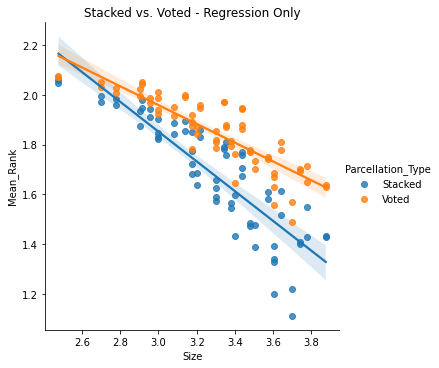

In [20]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False, regression_only=True)

sns.lmplot(x='Size', y='Mean_Rank', hue='Parcellation_Type', data=r_df)
plt.title('Stacked vs. Voted - Regression Only')
plt.savefig('Figures/ensemble_method_regression.png', dpi=200, bbox_inches='tight')

model = ols('Mean_Rank ~ Size * C(Parcellation_Type)', data=r_df).fit()
save_stats_summary(model, 'ensemble_method_regression')
print(model.pvalues)
model.summary()

### 3. Compare fixed size ensemble to across size ensemble

Intercept               6.877302e-116
C(Across_Sizes)[T.1]     1.875436e-37
Size                     3.525973e-75
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     870.8
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           4.14e-74
Time:                        11:30:05   Log-Likelihood:                 237.06
No. Observations:                 128   AIC:                            -468.1
Df Residuals:                     125   BIC:                            -459.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.2758      0.036     90.641      0.000       3.204       3.347
C(Across_Sizes)[T.1]     0.1409      0.008     18.433      0.000       0.126       0.156
Size                    -0.4695      0.011    -41.680      0.000      -0.492      -0.447
==============================================================================
Omnibus:                        4.198   Durbin-Watson:                   1.010
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                3.970
Skew:                          -0.431   Prob(JB):                        0.137
Kurtosis:                       3.021   Cond. No.                         38.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

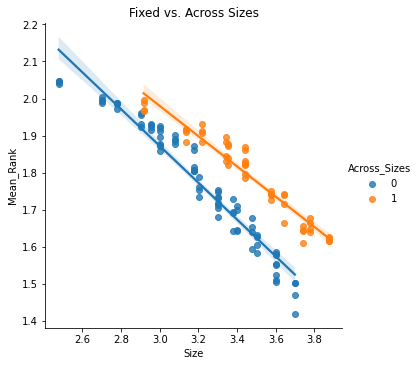

In [21]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False, by_group=False).sort_values('Size')
r_df['Across_Sizes'] = [1 if '-' in r else 0 for r in r_df.index]

sns.lmplot(x='Size', y='Mean_Rank', hue='Across_Sizes', data=r_df)
plt.title('Fixed vs. Across Sizes')

model = ols('Mean_Rank ~ Size + C(Across_Sizes)', data=r_df).fit()
save_stats_summary(model, 'fixed_vs_across')
print(model.pvalues)
model.summary()

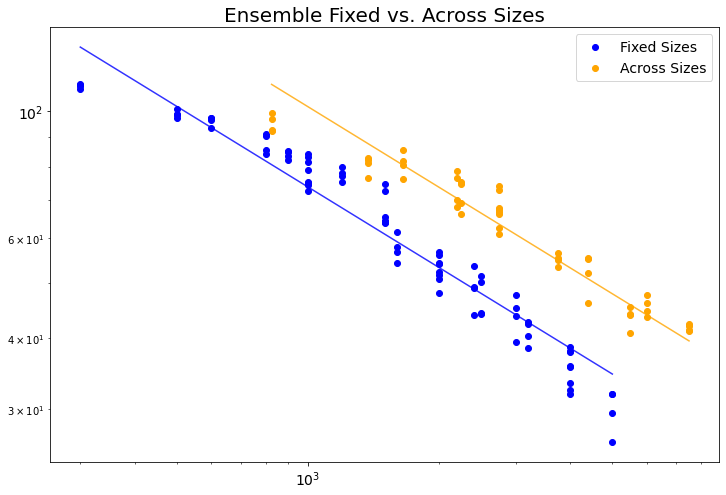

In [22]:
# Gen plot
_, ax = plt.subplots(figsize=(12, 8))

# Reverse log10 on size
e_size = 10 ** r_df['Size'][r_df['Across_Sizes'] == 0]
r_size = 10 ** r_df['Size'][r_df['Across_Sizes'] == 1]

e_rank = 10 ** r_df['Mean_Rank'][r_df['Across_Sizes'] == 0]
r_rank = 10 ** r_df['Mean_Rank'][r_df['Across_Sizes'] == 1]

# Get pred fit lines
e_fit = 10 ** model.params.Intercept * (e_size **(model.params.Size))

r_intercept = 10 ** (model.params.Intercept + model.params['C(Across_Sizes)[T.1]'])
r_fit = r_intercept * (r_size **(model.params.Size))

# Plot lines of fit
ax.plot(e_size, e_fit, color='blue', alpha=.8)
ax.plot(r_size, r_fit, color='orange', alpha=.8)

# Scatter points
ax.scatter(e_size, e_rank, color='blue', label='Fixed Sizes')
ax.scatter(r_size, r_rank, color='orange', label='Across Sizes')

# Formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_title('Ensemble Fixed vs. Across Sizes', fontsize=20)
plt.legend(fontsize=14)

plt.savefig('Figures/fixed_vs_across.png', dpi=200, bbox_inches='tight')

Check for size interactions on only a subset where they start at the same size

Intercept                    9.986308e-97
C(across_sizes)[T.1]         1.551295e-08
Size                         1.160429e-66
Size:C(across_sizes)[T.1]    9.757550e-13
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     753.0
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           4.78e-74
Time:                        11:30:06   Log-Likelihood:                 245.31
No. Observations:                 116   AIC:                            -482.6
Df Residuals:                     112   BIC:                            -471.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.6551      0.050     73.676      0.000       3.557       3.753
C(across_sizes)[T.1]         -0.4509      0.074     -6.100      0.000      -0.597      -0.304
Size                         -0.5839      0.015    -38.705      0.000      -0.614      -0.554
Size:C(across_sizes)[T.1]     0.1759      0.022      8.048      0.000       0.133       0.219
==============================================================================
Omnibus:                        0.105   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.949   Jarque-Bera (JB):                0.260
Skew:                           0.042   Prob(JB):                        0.878
Kurtosis:                       2.784   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

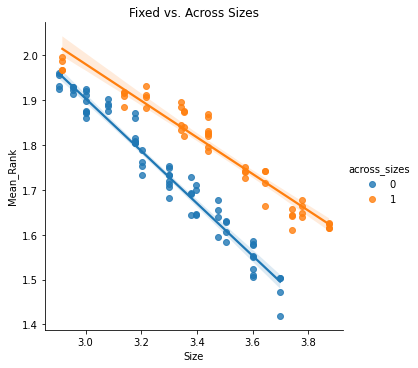

In [23]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False, by_group=False)
r_df['across_sizes'] = [1 if '-' in r else 0 for r in r_df.index]
r_df = r_df[r_df['Size'] > 2.9]

sns.lmplot(x='Size', y='Mean_Rank', hue='across_sizes', data=r_df)
plt.title('Fixed vs. Across Sizes')
plt.savefig('Figures/fixed_vs_across2.png', dpi=200, bbox_inches='tight')

model = ols('Mean_Rank ~ Size * C(across_sizes)', data=r_df).fit()
save_stats_summary(model, 'fixed_vs_across2')
print(model.pvalues)
model.summary()

4. Compare ‘Grid’ results to just random single parcellation results

restrict to: 100 1200
Intercept                         8.717259e-122
C(Parcellation_Type)[T.Random]     9.415719e-01
Size                               1.151680e-63
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     617.2
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           1.49e-62
Time:                        11:30:07   Log-Likelihood:                 243.21
No. Observations:                 119   AIC:                            -480.4
Df Residuals:                     116   BIC:                            -472.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          2.7432      0.024    115.943      0.000       2.696       2.790
C(Parcellation_Type)[T.Random]     0.0004      0.006      0.073      0.942      -0.011       0.012
Size                              -0.3143      0.009    -35.133      0.000      -0.332      -0.297
==============================================================================
Omnibus:                        1.385   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                1.303
Skew:                          -0.253   Prob(JB):                        0.521
Kurtosis:                       2.916   Cond. No.                         24.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

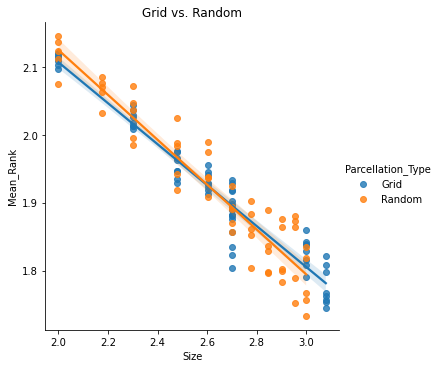

In [24]:
r_df = get_ranks_sizes(results, grid=True, random=True,
                       threshold=False, by_group=True, log=True)

# Get only random parcellations of the same size
g_sizes = r_df[r_df['Parcellation_Type'] == 'Grid']['Size']
g_max = g_sizes.max()
g_min = g_sizes.min()
print('restrict to:', round(10 ** g_min), round(10 ** g_max))
r_df = r_df[(r_df['Size'] >= g_min) & (r_df['Size'] <= g_max)]

d_df = r_df.rename(columns={'Mean_Rank': 'Mean Rank (log10)', 'Size': 'Size (log10)'})
sns.lmplot(x='Size', y='Mean_Rank', hue='Parcellation_Type', data=d_df)
plt.title('Grid vs. Random')

model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

# Highest Performance

 Inter pipeline ensemble results, to show that SVM based ensembles outperform other pipelines, use as justification for including them in Figure 6.

Intercept                6.869816e-166
C(Model)[T.lgbm]          6.050027e-10
C(Model)[T.svm]           1.467797e-15
Size                      3.070528e-25
Size:C(Model)[T.lgbm]     2.275896e-08
Size:C(Model)[T.svm]      9.546396e-22
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     364.3
Date:                Wed, 30 Jun 2021   Prob (F-statistic):          4.23e-142
Time:                        11:33:53   Log-Likelihood:                 490.90
No. Observations:                 384   AIC:                            -969.8
Df Residuals:                     378   BIC:                            -946.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.9596      0.060     49.020      0.000       2.841       3.078
C(Model)[T.lgbm]          0.5425      0.085      6.354      0.000       0.375       0.710
C(Model)[T.svm]           0.7116      0.085      8.334      0.000       0.544       0.879
Size                     -0.2042      0.018    -11.173      0.000      -0.240      -0.168
Size:C(Model)[T.lgbm]    -0.1476      0.026     -5.711      0.000      -0.198      -0.097
Size:C(Model)[T.svm]     -0.2637      0.026    -10.201      0.000      -0.315      -0.213
==============================================================================
Omnibus:                        3.229   Durbin-Watson:                   0.900
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.615
Skew:                           0.082   Prob(JB):                        0.270
Kurtosis:                       2.630   Cond. No.                         135.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

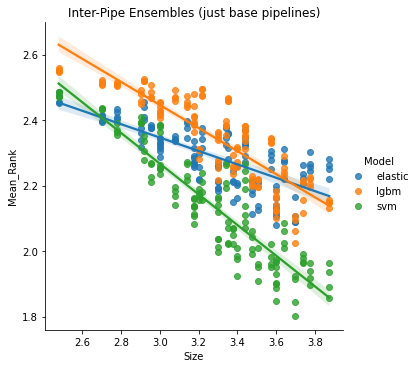

In [27]:
inter_pipe_df = get_across_ranks(results, drop_all=True,
                                 log=True, stacked=True, voted=True)

# Plot
sns.lmplot(x='Size', y='Mean_Rank', hue='Model', data=inter_pipe_df)
plt.title('Inter-Pipe Ensembles (just base pipelines)')
plt.savefig('Figures/ensemble_inter_pipe_stats.png', dpi=200, bbox_inches='tight')

# Model
model = ols('Mean_Rank ~ Size * C(Model)', data=inter_pipe_df).fit()
save_stats_summary(model, 'ensemble_inter_pipe_stats')
print(model.pvalues)
model.summary()

61 None
Smallest size: 273
Largest size: 5000
Intercept               1.676537e-158
C(Model)[T.existing]     3.776076e-07
C(Model)[T.svm]          2.578777e-27
Size                     1.112070e-94
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     790.3
Date:                Wed, 30 Jun 2021   Prob (F-statistic):          3.43e-105
Time:                        11:30:09   Log-Likelihood:                 316.38
No. Observations:                 189   AIC:                            -624.8
Df Residuals:                     185   BIC:                            -611.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.2950      0.035     94.479      0.000       3.226       3.364
C(Model)[T.existing]     0.0584      0.011      5.270      0.000       0.037       0.080
C(Model)[T.svm]          0.0929      0.007     12.813      0.000       0.079       0.107
Size                    -0.4434      0.011    -40.942      0.000      -0.465      -0.422
==============================================================================
Omnibus:                        0.132   Durbin-Watson:                   1.364
Prob(Omnibus):                  0.936   Jarque-Bera (JB):                0.153
Skew:                           0.062   Prob(JB):                        0.927
Kurtosis:                       2.936   Cond. No.                         36.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

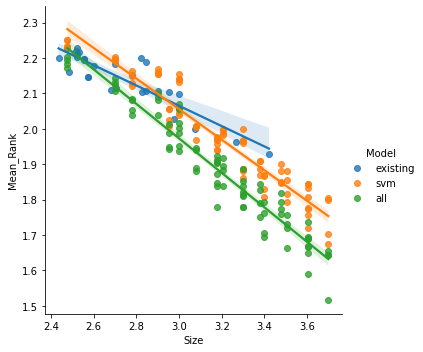

In [26]:
# get DF
r_df = get_highest_performing_df(results)

# Do Threshold
r_df = get_cut_off_df(r_df)
print('Smallest size:', r_df.sort_values('Size').iloc[0].Size)
print('Largest size:', r_df.sort_values('Size').iloc[-1].Size)

# Setup for plot
r_df = r_df.reset_index()
r_df['Mean_Rank'] = np.log10(r_df['Mean_Rank'])
r_df['Size'] = np.log10(r_df['Size'])

sns.lmplot(y='Mean_Rank', x='Size', data=r_df, hue='Model')

# Model
model = ols('Mean_Rank ~ Size + C(Model)', data=r_df).fit()
print(model.pvalues)
model.summary()